In [2]:
import os
import pandas as pd
import numpy as np
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import _gradient_boosting
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions_pipe_testing import *
from sklearn.metrics import  f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import *
from sklearn.preprocessing import LabelEncoder
from helper_functions_KP import *
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#Instructions for the pipeline Requires two inputs for training: - Mass spec data with corresponding NP surface characteristics and experimental conditions (time, concentration) - NetsurfP and Biopython data that has been precalculated - X characteristics to predict
pipeline Take mass spec spreadsheet Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration Merge with Proteome data to get file that has Accession,Enrichment,Dh,TEM,Zp,BET,Composition,Ligand,Shape,IncubationTime,IncubationConcentration,Mass,Length,Sequence Calculate protein features using biopython Merge with NSP data to get all protein features
Split into X and Y dataset with Entries as labels

In [3]:
#Editable Variables
#list of test filters
zerosperrow = [0.3]
for z in zerosperrow:
    multi_files = False  #set to false if you just want to set one  prot_abund_file
    in_dir = "Input_data/Proteomic data/Abundance2/"
    prot_abund_file = 'Input_data/Proteomic data/Abundance2/Norm_Intensity _all20230403.xlsx'
    NP_filepath = 'Input_data/NPs/NP_Database.xlsx'
    controls_file = 'Input_data/Proteomic data/controls_combined.xlsx'
    uniprot_filepath = 'Input_data/BioPython_data/Combined_biopyCalcs.xlsx'
    NSPfilePath = 'Input_data/NetSurfP_data/Combined.xlsx'
    id = 'scramble_NoCon_RFE40_droprows' + str(z) + 'zeros'
    RFE_Feats = 40
    # model = RandomForestRegressor(n_estimators=150)
    model=XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, objective='reg:squarederror')
    # take files in_dir and combine then into one pandas df (raw_MS_data) ###USE when combining multiple datasets####
    # melt the df to make it an accession number, NPUNID, Abundance dataset before combining
    files = os.listdir(in_dir)
    if multi_files == True:
        for i, f in enumerate(files):
            if i == 0:
                raw_MS_data = pd.read_excel(in_dir + f, header=0)
                cols = raw_MS_data.shape[1]
                cutoff = int(z * cols)
                print('shape before dropping rows', raw_MS_data.shape)
                raw_MS_data = raw_MS_data.drop(raw_MS_data[(raw_MS_data == 0).sum(axis=1) >= cutoff].index)
                print('shape after dropping rows', raw_MS_data.shape)
                # print(raw_MS_data)
                raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')

            else:

                temp = pd.read_excel(in_dir + f, header=0)
                cols = temp.shape[1]
                cutoff = int(z * cols)
                print('shape before dropping rows', raw_MS_data.shape)
                temp = temp.drop(temp[(temp == 0).sum(axis=1) >= cutoff].index)
                print('shape after dropping rows', raw_MS_data.shape)
                temp = pd.melt(temp, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')

                raw_MS_data = pd.concat([raw_MS_data, temp])
                print('final shape after melt', raw_MS_data.shape)
                print('number of zeros in the dataset:',(raw_MS_data == 0).sum().sum())

    else:
        raw_MS_data = pd.read_excel(prot_abund_file, header=0)
        cols = raw_MS_data.shape[1]
        cutoff = int(z * cols)
        print('shape beofre dropping rows', raw_MS_data.shape)
        raw_MS_data = raw_MS_data.drop(raw_MS_data[(raw_MS_data == 0).sum(axis=1) >= cutoff].index)
        print('shape after dropping rows', raw_MS_data.shape)
        raw_MS_data = pd.melt(raw_MS_data, id_vars=['Entry'], var_name='Sample_num', value_name='Abundance')
    #remove prots that were added due to merge
    raw_MS_data = raw_MS_data.dropna()
    ###Bring in controls (MS data for serums)##
    controls = pd.read_excel(controls_file, header=0)
    MS_data_controls = pd.merge(raw_MS_data, controls, how='left', on='Entry')
    ###Bring in Uniprot_data,NSPdata and NP data##
    uniprot_dat = pd.read_excel(uniprot_filepath, header=0)
    NSP_data = pd.read_excel(NSPfilePath)
    ###Bring in NP data and merge to get complete NP dataset###
    NPUNdata = pd.read_excel(NP_filepath, header=0, sheet_name='NPUNID')
    NPprop = pd.read_excel(NP_filepath, header=0, sheet_name='NP_Props')
    NPdata = pd.merge(NPUNdata, NPprop, how="left", on='NPID')
    NPdata.dropna(inplace=True)
    #calculate Enrichment
    #####MAYBE add binning here to keep negative results and improve capapbilities######
    # MS_data_controls['Enrichment']= np.log2(MS_data_controls['Abundance']/MS_data_controls['Abundance_Controls'])
    # MS_data=MS_data_controls.drop(columns=['Abundance','Abundance_Controls'])
    #keep abundance Controls
    # MS_data=MS_data_controls.drop(columns=['Abundance'])
    raw_prop_data = pd.merge(MS_data_controls, uniprot_dat.drop_duplicates(subset=['Entry']), how='left', on='Entry')
    Protein_data_complete = pd.merge(raw_prop_data, NSP_data.drop_duplicates(subset=['Entry']), how='left',
                                     on='Entry')
    #merges netsurfp features and biopython features
    Protein_data_complete.fillna(0, inplace=True)
    #creates new column called asa_sum_normalized which is the asa_sum value divide by the mass of the protein
    # for df in [Protein_data_complete]:
    #     for col in ['asa_sum']:
    #         df[col + '_normalized'] = df[col] / df['Mass']

    data_complete = pd.merge(Protein_data_complete, NPdata, how='inner', on='Sample_num')
    data_complete.drop(columns=['notes', 'Notes', 'NPUNID'], inplace=True)
    data_complete.fillna(0, inplace=True)
    data_complete = data_complete.replace([-np.inf], '-12')
    data_complete = data_complete.replace([np.inf], '12')
    #create ordinal variables
    le = LabelEncoder()
    data_complete['Core Material'] = le.fit_transform(data_complete['Core Material'])
    data_complete['Surface_Ligand'] = le.fit_transform(data_complete['Surface_Ligand'])
    data_complete = data_complete.sample(frac=1)
    #set labels (what we are trying to predict) as Abundance

    label_abund = np.ravel(data_complete['Abundance'].copy())
    label_abund_df = pd.DataFrame(label_abund)

    #make it one dimenisional
    #drop qualitative, not neccessary, and label columns
    #create df without bonus NSP columns (remove total_exposed) There are too sets of features total_exposed and exposed_exposed
    to_drop = data_complete.filter(like='total_exposed_')
    data_complete.drop(columns=to_drop, inplace=True)
    df = data_complete.drop(
        ['Entry', 'Abundance', 'Sequence', 'NPID', 'Ligands', 'Protein Source', 'Sample_num', 'Unnamed: 5',
         'Raw_FileID'], axis=1)
    df.drop(columns=['Abundance_Controls'], inplace=True)

    # df.to_excel("Input_data/Save_files/df_"+id+".xlsx")
    # label_abund_df.to_excel("Input_data/Save_files/label_abund"+id+".xlsx",index=False)

    #Run PCA to seee how data differentiates#
    PCA_plot(df,label_abund,id)
    #use recursive feature elimination with Random Forest Regression as the estimator to select top 45 important features
    step = 2
    estimator = RandomForestRegressor(n_estimators=100)
    selector = RFE(estimator, n_features_to_select=RFE_Feats, step=step)
    selector = selector.fit(df, label_abund)
    selector.support_
    ranking = selector.ranking_
    feat_list = selector.get_feature_names_out()
    df = df[feat_list]

    #run Recursive feature elimination with cross validation
    df = RFECV_plot(df,label_abund,model,id,folds=10,step=2)

    #Quality control
    scram_score(df, label_abund, model, id, 0.2)
    feat_drop(df, label_abund, model, id, 0.2)
    feat_drop_multifold(df, label_abund, model, id, 0.2, folds=5)
    scorer(df, label_abund, model, id, 10)

print('done')


shape beofre dropping rows (568, 56)
shape after dropping rows (118, 56)
Recursive Feature Elimination with Correlated Features ran successfully


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:asa_sum_normalized: object

In [4]:
data_complete

,Entry,Sample_num,Abundance,Abundance_Controls,Unnamed: 5,Sequence,Length,Mass,frac_aa_A,frac_aa_C,...,Dh_functionalized,Shaken,Centrifuged,ProteinID,Protein Source,NP_incubation Concentration (mg/mL),Incubation Concentration (mg/ml),Corona_Concentration (ug/mg),Incubation Time (minutes),Temperature
1193,Q9N2I2,43,0.188229,0.062018,0.0,MRLCLFLCLVLLGPRMATLRRSQKKKIQEVPPAVTTAPPGSRDFVF...,404.0,45297.0,0.071782,0.007426,...,288.0,1,0,1,FBS,5.0,40.0,507.357144,30,25
811,Q3ZBN5,39,0.129667,0.000000,0.0,MKVYVLLVFLTLCSAKPLFHPSYLTLKNLMLKDMEDEGDSDADNSL...,370.0,42119.0,0.037838,0.018919,...,271.0,1,0,1,FBS,5.0,40.0,51.820745,30,25
748,P28800,39,0.292146,0.300676,0.0,MALLWGLLALILSCLSSLCSAQFSPVSTMEPLDLQLMDGQAQQKLP...,492.0,54711.0,0.075203,0.010163,...,271.0,1,0,1,FBS,5.0,40.0,51.820745,30,25
524,P81948,37,0.016983,0.000000,0.0,MRECISVHVGQAGVQMGNACWELYCLEHGIQPDGQMPSDKTIGGGD...,448.0,49924.0,0.080357,0.029018,...,316.0,1,0,1,FBS,5.0,40.0,56.774264,30,25
161,P81187,34,3.458451,0.232007,0.0,MGIGHNPRLCLVPLILGLLCGGVGMTPLPEAGPQSPCSLEGVEIKG...,761.0,85366.0,0.052562,0.032852,...,229.0,1,0,1,FBS,5.0,4.0,24.697213,30,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,P13384,35,0.035472,0.003092,0.0,MQPRLGGPALLLLPPLLLLLLLGAGGGDCGARAEVLFRCPPCTPES...,317.0,34015.0,0.066246,0.059937,...,226.0,1,0,1,FBS,5.0,4.0,122.773587,30,25
1412,Q3ZBX9,44,0.003003,0.000000,0.0,MSGRGKQGGKVRAKAKSRSSRAGLQFPVGRVHRLLRKGNYAERVGA...,129.0,14019.0,0.116279,0.000000,...,316.0,1,0,1,FBS,5.0,4.0,27.929767,30,25
519,Q27967,37,0.049319,0.000218,0.0,MEKMAMKMLVIFVLGMNHWTCTGFPVYDYDPASLKEALSASVAKVN...,203.0,23134.0,0.059113,0.024631,...,316.0,1,0,1,FBS,5.0,40.0,56.774264,30,25
733,Q95121,39,0.289006,0.084978,0.0,MQALVLLLWTGALLGFGRCQNAGQEAGSLTPESTGAPVEEEDPFFK...,416.0,46229.0,0.067308,0.004808,...,271.0,1,0,1,FBS,5.0,40.0,51.820745,30,25


In [ ]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for fold_idx, (train_index, test_index) in enumerate(kfold.split(df, label_abund)):
    print(fold_idx)

In [ ]:
feat_drop(df, label_abund, model, id, 0.2)

In [ ]:
x=[1,2,3,4]
y=[1,2,3,4]
y2=[2,4,6,8]
y3=[4,8,12,16]

plt.plot(x, y, color='tab:blue', marker='o',label='pearson')
plt.plot(x, y2, color='tab:red', marker='s',label='R2')
plt.plot(x, y3, color='tab:green', marker='^',label='mse')
plt.legend()

plt.title('Score as a function of Feat Drop\n'+id)
plt.savefig('Output_data/feat_drop_cumulative' + id + '.png', bbox_inches='tight')

In [ ]:
print(y2)

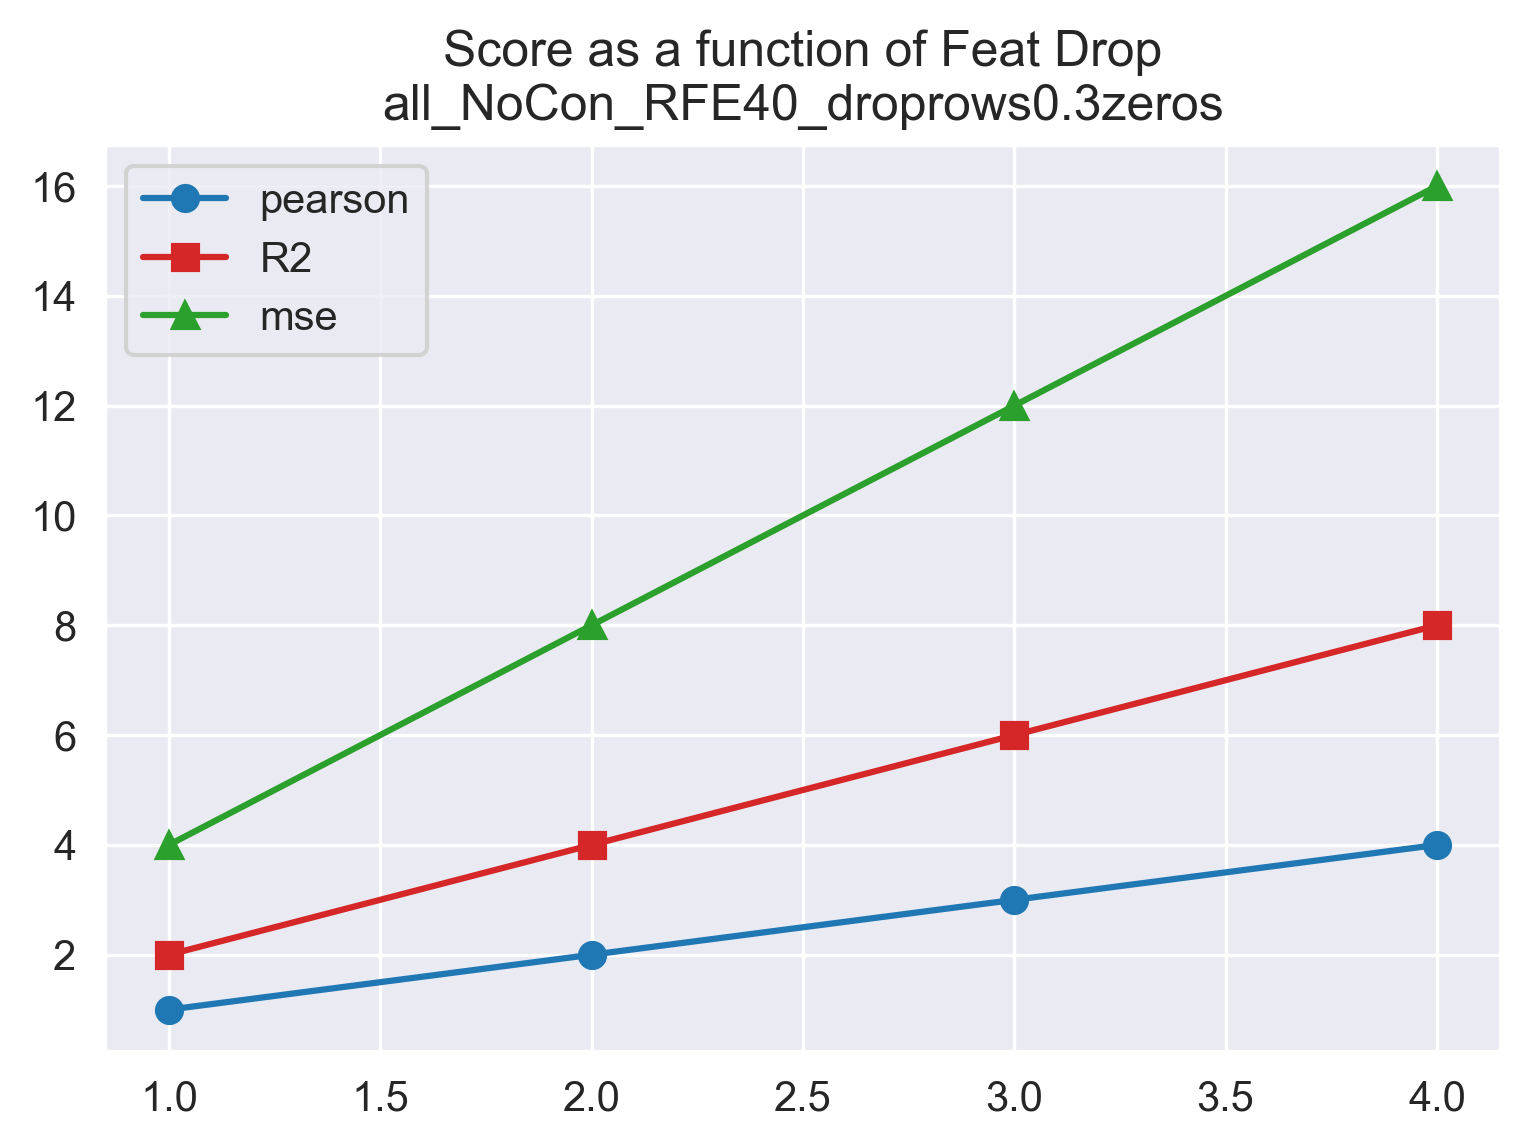

In [7]:
x=[1,2,3,4]
y=[1,2,3,4]
y2=[2,4,6,8]
y3=[4,8,12,16]

plt.plot(x, y, color='tab:blue', marker='o',label='pearson')
plt.plot(x, y2, color='tab:red', marker='s',label='R2')
plt.plot(x, y3, color='tab:green', marker='^',label='mse')
plt.legend()

plt.title('Score as a function of Feat Drop\n'+id)
plt.savefig('Output_data/feat_drop_cumulative' + id + '.png', bbox_inches='tight')

In [6]:
print(y2)

[1, 2, 3, 4, 1, 2, 3, 4]


In [4]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [7]:
scorer(df, label_abund, model, id, 10)

Scorer ran successfully


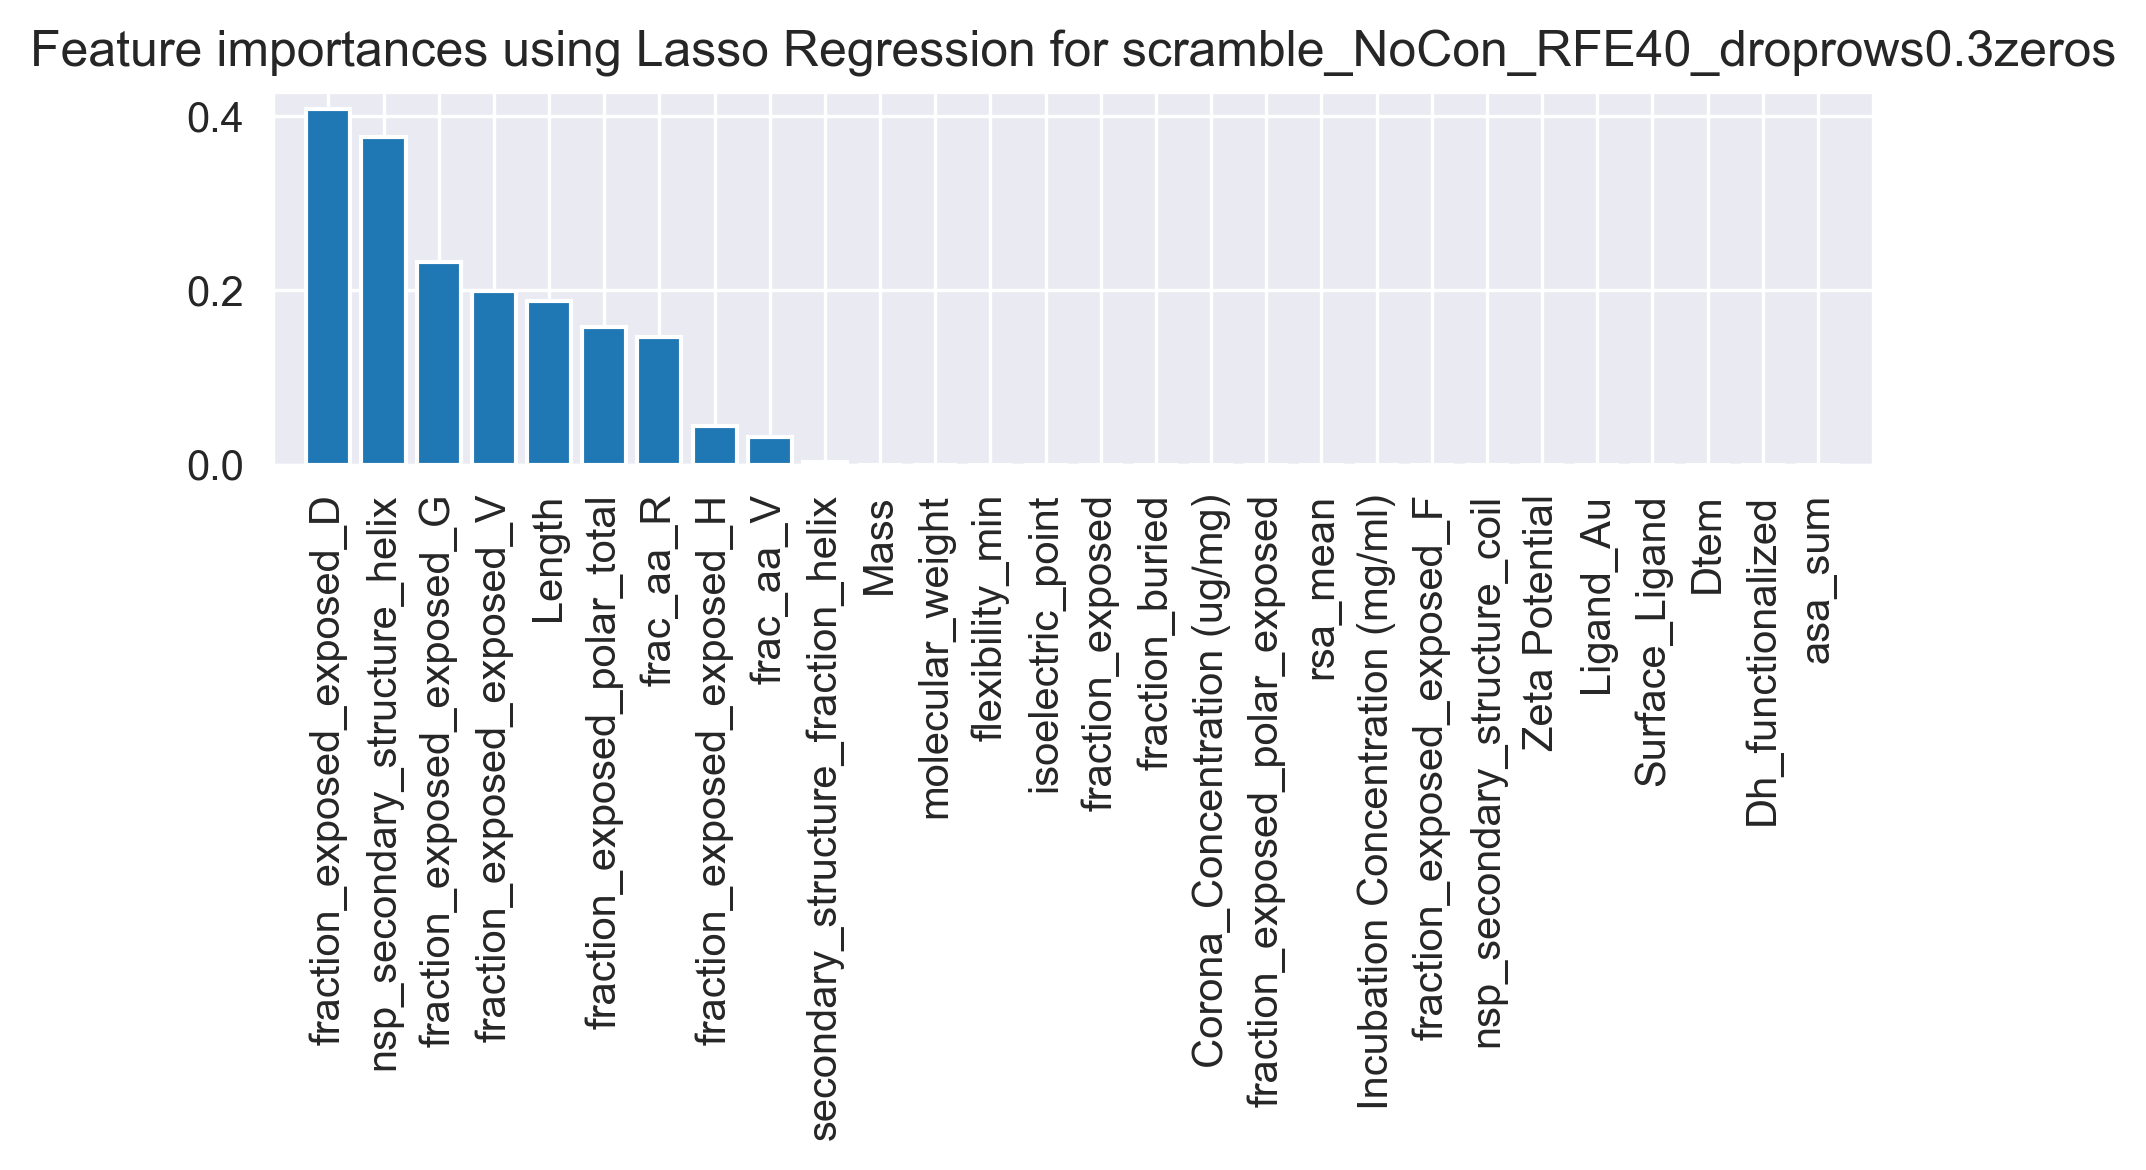

<Figure size 1800x1200 with 0 Axes>

In [4]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
X=df
y= label_abund
identifier=id

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform Lasso regression
lasso = Lasso(alpha=0.1, random_state=42)
pipe = Pipeline([('scaler', scaler), ('lasso', lasso)])
pipe.fit(X, y)

# Get feature importances
importances = np.abs(pipe.named_steps['lasso'].coef_)
feature_names = X.columns

# Sort features by importance
sorted_idx = importances.argsort()[::-1]
importances = importances[sorted_idx]
feature_names = feature_names[sorted_idx]

# Create plot of feature importances
plt.figure()
plt.title("Feature importances using Lasso Regression for {}".format(identifier))
plt.bar(range(X.shape[1]), importances)
plt.xticks(range(X.shape[1]), feature_names, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()
importance_plot = plt.gcf()

# Reduce dataset to high-importance features
X_reduced = X.iloc[:,sorted_idx[:10]]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def lasso_feature_selection(X, y, identifier):
    """
    Performs Lasso regression feature selection on the input dataset X and target variable y using the specified estimator.
    Returns a reduced dataset with high-importance features and a plot of the feature importances.

    Parameters:
    -----------
    X : pandas DataFrame
        The input dataset containing the features to be used for regression.

    y : numpy array
        The target variable for regression.

    identifier : str
        An identifier to be used in the plot title.

    estimator : scikit-learn estimator object
        An estimator to be used for Lasso regression.

    Returns:
    --------
    X_reduced : pandas DataFrame
        The reduced dataset containing only the high-importance features.

    importance_plot : matplotlib figure
        A plot of the feature importances.
    """

    # Scale the input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform Lasso regression
    lasso = Lasso(alpha=0.1, random_state=42)
    pipe = Pipeline([('scaler', scaler), ('lasso', lasso)])
    pipe.fit(X, y)

    # Get feature importances
    importances = np.abs(pipe.named_steps['lasso'].coef_)
    feature_names = X.columns

    # Sort features by importance
    sorted_idx = importances.argsort()[::-1]
    importances = importances[sorted_idx]
    feature_names = feature_names[sorted_idx]

    # Create plot of feature importances
    plt.figure()
    plt.title("Feature importances using Lasso Regression for {}".format(identifier))
    plt.bar(range(X.shape[1]), importances)
    plt.xticks(range(X.shape[1]), feature_names, rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.tight_layout()
    importance_plot = plt.gcf()

    # Reduce dataset to high-importance features
    X_reduced = X.iloc[:,sorted_idx[:10]]

    return X_reduced, importance_plot


C:\Users\kmp95\AppData\Local\Temp\ipykernel_20260\967082878.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feats, rotation=90)


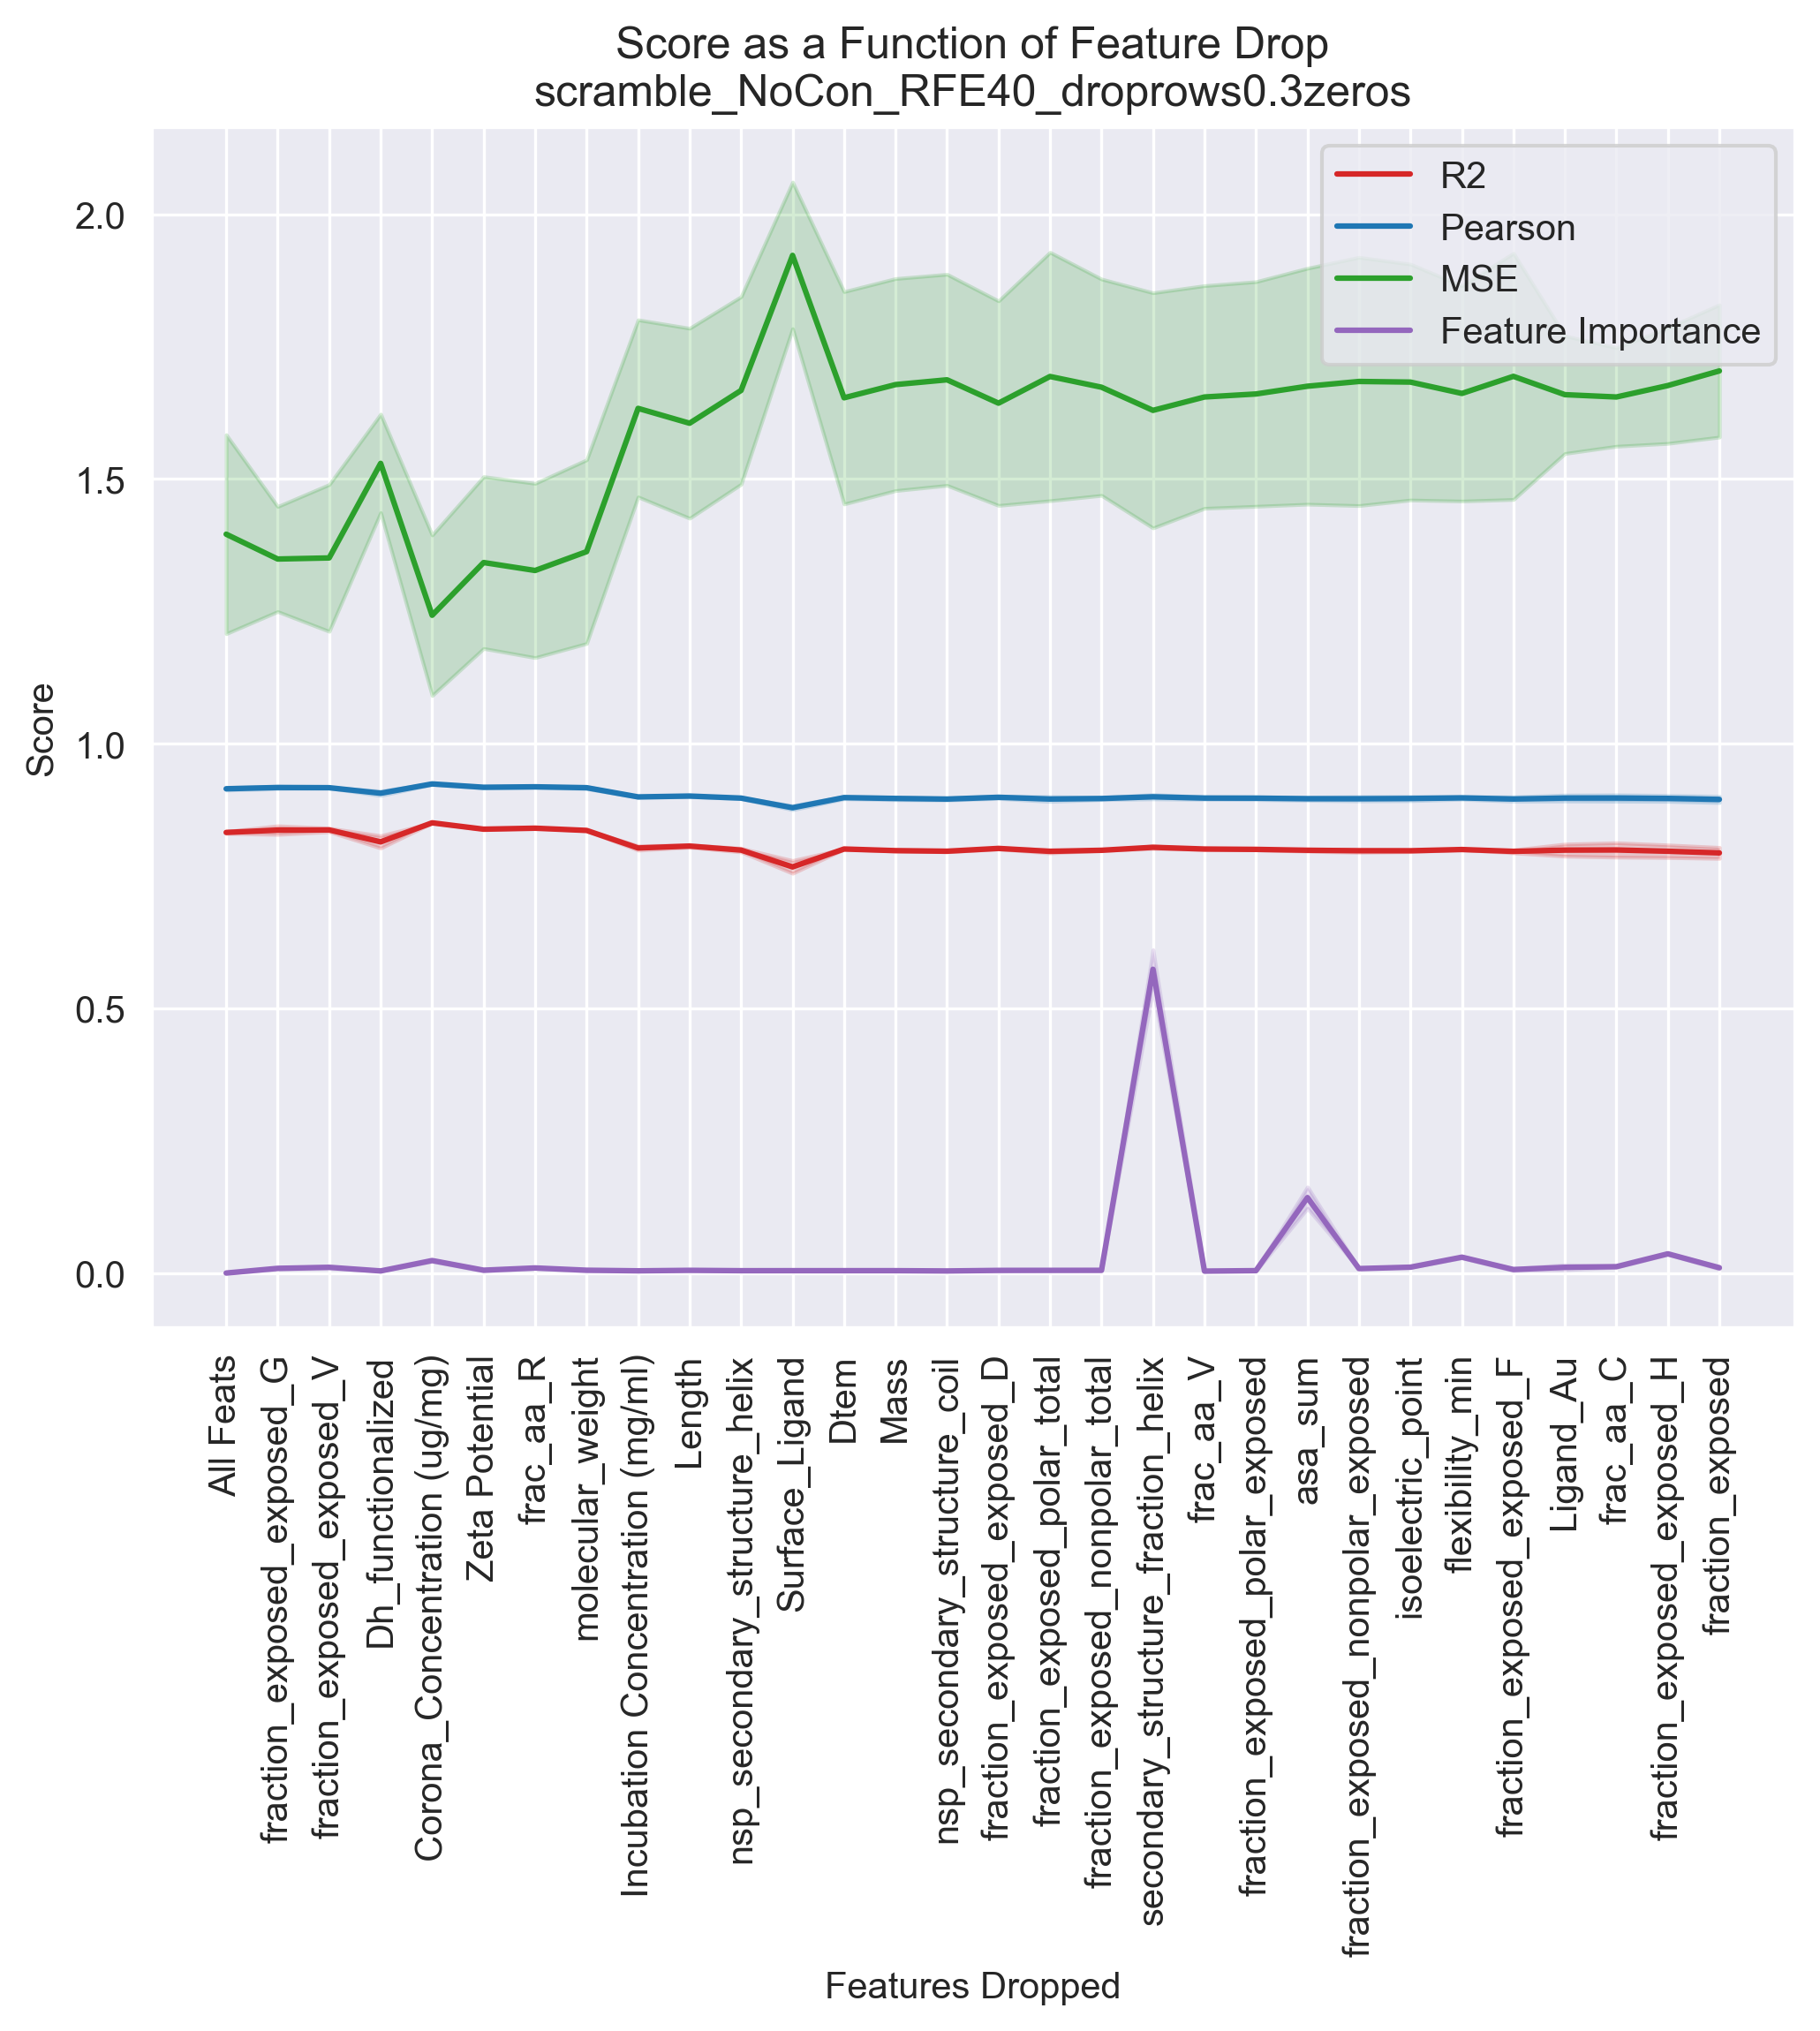

In [27]:
label=label_abund
folds=2
test_percent=0.2
feats = []
r2s = []
pearson = []
mse = []
feat_importances = []

kf = KFold(n_splits=folds, shuffle=True, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(df, label, test_size=test_percent, random_state=42)
model.fit(x_train, y_train)
feat_import = model.feature_importances_

a = list(zip(feat_import, df.columns))
a.sort(reverse=True)
col_import = pd.DataFrame(a, columns=['importances', 'names'])
sorted_cols = col_import['names']
feats.append('All Feats')
feats.extend(sorted_cols.tolist())
feats=feats[:-1]

for train_index, test_index in kf.split(df):
    x_train, x_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = label[train_index], label[test_index]

    model.fit(x_train, y_train)
    predictions = model.predict(x_test)

    r2 = r2_score(y_test, predictions)
    corr, _ = pearsonr(y_test, predictions)
    mse_score = mean_squared_error(y_test, predictions)
    feat_import = model.feature_importances_

    a = list(zip(feat_import, df.columns))
    a.sort(reverse=True)

    feat_import = np.insert(feat_import, [0], 0)
    feat_import = np.delete(feat_import, [-1])


    r2s.append(r2)
    pearson.append(corr)
    mse.append(mse_score)
    feat_importances.append(feat_import)

    df_3 = df.copy()
    for i in sorted_cols:
        if i == sorted_cols.iloc[-1]:
            break
        df_3.drop(columns=[i], inplace=True)
        x_train, x_test = df_3.iloc[train_index], df_3.iloc[test_index]
        y_train, y_test = label[train_index], label[test_index]

        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        r2 = r2_score(y_test, predictions)
        corr, _ = pearsonr(y_test, predictions)
        mse_score = mean_squared_error(y_test, predictions)
        r2s.append(r2)
        pearson.append(corr)
        mse.append(mse_score)

feats = np.array(feats)
r2s = np.array(r2s).reshape(folds, -1)
pearson = np.array(pearson).reshape(folds, -1)
mse = np.array(mse).reshape(folds, -1)
feat_importances = np.array(feat_importances).reshape(folds, -1)

import matplotlib.pyplot as plt

mean_r2s = np.mean(r2s, axis=0)
std_r2s = np.std(r2s, axis=0)
mean_pearson = np.mean(pearson, axis=0)
std_pearson = np.std(pearson, axis=0)
mean_mse = np.mean(mse, axis=0)
std_mse = np.std(mse, axis=0)
mean_feat_importances = np.mean(feat_importances, axis=0)
std_feat_importances = np.std(feat_importances, axis=0)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot R2 scores
ax.plot(feats, mean_r2s, color='tab:red', label='R2')
ax.fill_between(feats, mean_r2s - std_r2s, mean_r2s + std_r2s, alpha=0.2, color='tab:red')

# Plot Pearson correlation coefficients
ax.plot(feats, mean_pearson, color='tab:blue', label='Pearson')
ax.fill_between(feats, mean_pearson - std_pearson, mean_pearson + std_pearson, alpha=0.2, color='tab:blue')

# Plot mean squared errors
ax.plot(feats, mean_mse, color='tab:green', label='MSE')
ax.fill_between(feats, mean_mse - std_mse, mean_mse + std_mse, alpha=0.2, color='tab:green')

# Plot feature importances
ax.plot(feats, mean_feat_importances, color='tab:purple', label='Feature Importance')
ax.fill_between(feats, mean_feat_importances - std_feat_importances, mean_feat_importances + std_feat_importances,
                alpha=0.2, color='tab:purple')

ax.set_xticklabels(feats, rotation=90)
ax.legend()

ax.set_title('Score as a Function of Feature Drop\n{}'.format(id))
ax.set_xlabel('Features Dropped')
ax.set_ylabel('Score')

plt.savefig('Output_data/feat_drop_multifold_{}.png'.format(id), bbox_inches='tight')
plt.show()
plt.close(fig)


In [25]:
feat_import

array([0.        , 0.01212939, 0.01140085, 0.00428974, 0.02420485,
       0.00431578, 0.0125204 , 0.00617384, 0.00470139, 0.00546684,
       0.0046414 , 0.00618301, 0.00488163, 0.00594837, 0.00429777,
       0.00452434, 0.00487506, 0.00365123, 0.52052112, 0.00407559,
       0.00359755, 0.16514551, 0.01050119, 0.01085259, 0.03103084,
       0.00343577, 0.01518744, 0.01260424, 0.04124317, 0.01148234])